<img src='https://www.cars24.com/blog/wp-content/uploads/2018/07/Myths-about-buying-a-used-car-3.jpg' style="width:800px; height:400px">

# ASSIGNMENT 1: Used Cars Price Prediction and Evaluation

<br>

### Table Of Contents:
1. [Data Cleaning](#clean)
2. [Data Visualisation](#visual)
    * [Companies. Their Models and Mean Selling Price.](#v1) 
    * [Popularity By Make/company](#v2)
    * [Popularity By Segment](#v3)
    * [Popularity By Colour](#v4)
    * [Popularity of Segment in Each Make](#v5)
    * [Fuel Type in Each Make](#v6)
    * [Price Variation](#v7)
    * [Price VS Make ](#v8)
    * [Price VS Segment](#v9)
    * [Price VS Year](#v10)
    * [Price VS Distance travelled by Car](#v11)
    <br>
3. [Feature Selection](#featureSelection)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_rows',None)
sns.set_theme(style='darkgrid',font='fantasy')

In [3]:
df = pd.read_csv('cars_price.csv',index_col = 'Unnamed: 0')
df.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,honda,accord,565,1993,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,ford,fusion,5550,2008,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,nissan,teana,8300,2008,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,volkswagen,fox,3300,2005,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,nissan,primera,2450,2002,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


The following columns need to be clearly understood:
* make : The brand of the car
* model: Model of the car
* priceUSD: Selling Price of the used car in US Dollars.
* year : Year in which the car was bought/launched.
* mileage(kilometers) : It actually refers to the total distance travelled by the car till now, and not the mileage. The column name is wrongly written.
* fuel_type: Either of petrol, diesel or electric.
* transmission: The type of transmission used by the car.(Automatic/Manual)
* volume(cm3) : Car engine displacement in cc.

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
df.nunique()

In [ ]:
print('condition:   ',df.condition.unique())
print('Fuel Type:   ',df.fuel_type.unique())
print('Color:       ',df.color.unique())
print('Transmission:',df.transmission.unique())
print('Drive unit:  ',df.drive_unit.unique())
print('Segment:     ',df.segment.unique())

In [ ]:
df.groupby(['make','model','segment']).first()

<br>

# DATA CLEANING <a class="anchor" id="clean"></a>

#### Detect and remove Outliers in Volume(cc)

From the general knowledge, it is clear that engine dispalcement (cc) of any car built till now is in between some hundred-cc to 6000cc or 7000cc.
Any engine displacement value beyond that can be treated as outlier. Such values in the data are extracted out and studied. 
I replaced these values with the median volume(cc) of the car of same model and make. 

In [ ]:
# df[df['volume(cm3)'] >= 7000].sort_values(by='volume(cm3)',ascending=True)

In [ ]:
sns.set_context('notebook')
sns.boxplot(x=df['volume(cm3)'])

In [ ]:
sns.set_context('poster')
sns.relplot(data=df,x='year',y='volume(cm3)',kind='scatter',height=6,aspect=1.5,hue='fuel_type',col='transmission')

In [4]:
c = df[df['volume(cm3)'] >= 7000].sort_values(by='volume(cm3)',ascending=True)
# c

In [5]:
new_df = df.drop(c.index)
for a, b in zip(c.iloc[:, 0], c.iloc[:, 1]):
    f = new_df[(new_df['make']==a) & (new_df['model']==b)]
    c.loc[(c['make']==a) & (c['model']==b), 'volume(cm3)'] = f['volume(cm3)'].median()
df = pd.concat([new_df,c],ignore_index=True)

In [6]:
df.shape

(40000, 12)

In [7]:
df[df['volume(cm3)'] >= 7000].sort_values(by='volume(cm3)',ascending=True)

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment


In [8]:
df['volume(cm3)'].isna().sum()

30

In [9]:
df['volume(cm3)'].fillna(0,inplace=True)

In [10]:
df['volume(cm3)'].isna().sum()

0

<br>

<br>

# DATA VISUALISATIONS <a class="anchor" id="visual"></a>

### Car companies. Their  Models and Mean Selling Price <a class="anchor" id="v1"></a>

In [ ]:
df1 = df.groupby(['make','model'])[['volume(cm3)','priceUSD']].agg([np.mean]).sort_values(['make',('volume(cm3)','mean')],ascending=[True,False])
df1

<br>

### Popularity By Make <a class="anchor" id="v2"></a>

In [ ]:
sns.catplot(data=df, x='make', kind="count", palette="rocket",height=10,aspect=3,order = df['make'].value_counts().index)
plt.title('POPULAR CAR COMPANIES',fontsize=30)
plt.xticks(rotation=90)
plt.show()

<br>

### Popularity By Segment<a class="anchor" id="v3"></a>

In [ ]:
sns.set_context('notebook')
sns.catplot(data= df.sort_values('segment'), x='segment', kind="count", palette="ch:s=.25,rot=-.25",aspect=1.5)
plt.title('POPULAR CAR SEGMENTS',fontsize=18)
plt.show()

<br>

### Popularity By Color <a class="anchor" id="v4"></a> 

In [ ]:
sns.set_context('notebook')
sns.catplot(y="color", data=df,kind='count',aspect=1.5,order=df.color.value_counts().index,palette='mako')
plt.title('POPULAR CAR COLORS',fontsize=20)

<br>

### Popularity By Segment in each Make<a class="anchor" id="v5"></a>

In [ ]:
sns.set_context('poster')
sns.displot(df.sort_values('make'), x="make", hue="segment",hue_order= ['A','B','C','D','E','F','J','M','S'], multiple="stack",height=10,aspect=3,palette='bright')
plt.title('CAR POPULARITY BY SEGMENT IN EACH MAKE',fontsize=30)
plt.xticks(rotation=90)
plt.show()

<br>

### Popularity By Fuel Type in each Make<a class="anchor" id="v6"></a>

In [ ]:
sns.displot(df.sort_values('make'), x="make", hue="fuel_type", multiple="stack",height=10,aspect=3,palette='mako')
plt.title('CAR POPULARITY BY FUEL TYPE IN EACH  MAKE',color='black',fontsize=30,fontweight=5)
plt.xticks(rotation=90)
plt.show()

<br>

###  Selling Price Variation<a class="anchor" id="v7"></a>

In [ ]:
sns.set_context('notebook')
sns.displot(df,x='priceUSD',aspect=2,kind='hist',kde=True,color='green')

<br>

### Price Range of Each Make<a class="anchor" id="v8"></a>

In [ ]:
sns.set_context('poster')
sns.catplot(data=df,x='make',y='priceUSD',height=10,aspect=3,kind='box',order = df['make'].value_counts().index,palette='bright')
plt.xticks(rotation=90)
plt.show()

<br>

### Price Range of Each Segment<a class="anchor" id="v9"></a>

In [ ]:
sns.catplot(data=df,x='segment',y='priceUSD',height=10,aspect=3,kind='box',order = df['segment'].value_counts().index,palette='bright')
plt.show()

<br>

### Year  vs  Price(USD)<a class="anchor" id="v10"></a>

In [ ]:
sns.relplot(data=df,x='year',y='priceUSD',kind='line',height=6,aspect=1.5,ci=None,col='transmission',hue='fuel_type',palette='bright')

<br>

### Price VS Car Distance travelled<a class="anchor" id="v11"></a> 

In [ ]:
sns.relplot(data=df,x='mileage(kilometers)',y='priceUSD',height=7,aspect=1.5,col='transmission')

<br>

<br>

# FEATURE SELECTION <a class="anchor" id="featureSelection"></a> 

In [11]:
df.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,honda,accord,565,1993,with mileage,960015.0,petrol,2000.0,black,mechanics,front-wheel drive,D
1,ford,fusion,5550,2008,with mileage,172000.0,diesel,1400.0,silver,mechanics,front-wheel drive,M
2,nissan,teana,8300,2008,with mileage,223000.0,petrol,2500.0,purple,auto,front-wheel drive,D
3,volkswagen,fox,3300,2005,with mileage,140000.0,petrol,1200.0,blue,mechanics,front-wheel drive,A
4,nissan,primera,2450,2002,with damage,413000.0,diesel,2200.0,burgundy,mechanics,front-wheel drive,D


In [14]:
df.shape

(35019, 12)

In [13]:
df.dropna(inplace=True)

In [15]:
X = df.drop('priceUSD',axis=1)

In [16]:
Y = df.priceUSD

In [17]:
X.shape,Y.shape

((35019, 11), (35019,))

In [18]:
categ_df = X.select_dtypes(include=['object'])
num_df = X.select_dtypes(exclude=['object'])

<BR>

#### NUMERICAL COLUMNS

I used heatmap to find the corelation between target('price of the car') and indivdual numerical features. This gave the most important numerical features to include in final model for better performance.  

In [19]:
num_df.head()

,year,mileage(kilometers),volume(cm3)
0,1993,960015.0,2000.0
1,2008,172000.0,1400.0
2,2008,223000.0,2500.0
3,2005,140000.0,1200.0
4,2002,413000.0,2200.0


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
fs = SelectKBest(score_func=f_regression,k=2)
X_selected = fs.fit_transform(num_df,Y)
X_selected

In [ ]:
sns.heatmap(df.corr(), annot=True,cmap="gist_yarg")

The corr. heatmap gave expected results:
* Price of the car is more when it belongs to recent year. (corr. coef. = 0.61)
* Price of the car tends to get lower when it has already run a significant distance.(negative corr.)
* Cars with greater engine dispalcecment(volume) have more price. (corr coeff. = 0.37) <br><br>
Also there is no colinearity among the features of data.

In [ ]:
sns.pairplot(data=df,dropna=True)

In [ ]:
# min_max_scaler = preprocessing.MinMaxScaler()
# num_df_scaled = min_max_scaler.fit_transform(num_df.values)
# num_df_scaled = pd.DataFrame(num_df_scaled)

In [ ]:
# num_df_scaled.rename(columns={0:'year',1:'mileage(kilometers)',2:'volume(cm3)'},inplace=True)
# num_df_scaled.head()

<br>

#### CATEGORICAL COLUMNS

In [20]:
categ_df.head()

,make,model,condition,fuel_type,color,transmission,drive_unit,segment
0,honda,accord,with mileage,petrol,black,mechanics,front-wheel drive,D
1,ford,fusion,with mileage,diesel,silver,mechanics,front-wheel drive,M
2,nissan,teana,with mileage,petrol,purple,auto,front-wheel drive,D
3,volkswagen,fox,with mileage,petrol,blue,mechanics,front-wheel drive,A
4,nissan,primera,with damage,diesel,burgundy,mechanics,front-wheel drive,D


In [ ]:
for i in ['segment','fuel_type','transmission','drive_unit','condition','color']:
    plt.figure()
    df[i].value_counts().plot(kind='bar')
    plt.show()

In [ ]:
for i in ['segment','fuel_type','transmission','drive_unit','condition','color']:
    plt.figure()
    sns.catplot(data=df,x=i,y='priceUSD',height=5,aspect=2,kind='box',order=df.groupby([i])['priceUSD'].agg([np.median]).sort_values(by='median',ascending=False).index)
    plt.xticks(rotation=90)
    plt.show()
    print('\t\t\t\t\t',i,'vs Price Of Car\n')

<br>

In [21]:
categ_df.drop(['make','model'],axis=1,inplace=True)

In [22]:
categ_df.isna().sum()

condition       0
fuel_type       0
color           0
transmission    0
drive_unit      0
segment         0
dtype: int64

In [30]:
df1 = pd.get_dummies(categ_df)

In [31]:
df1.shape

(35019, 34)

In [32]:
df1.head()

,condition_for parts,condition_with damage,condition_with mileage,fuel_type_diesel,fuel_type_electrocar,fuel_type_petrol,color_black,color_blue,color_brown,color_burgundy,...,drive_unit_rear drive,segment_A,segment_B,segment_C,segment_D,segment_E,segment_F,segment_J,segment_M,segment_S
0,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(categ_df, Y, test_size=0.33, random_state=1)

In [24]:
def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

In [25]:
from sklearn.preprocessing import OrdinalEncoder
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

In [29]:
X_train_enc.shape

(23462, 6)

In [36]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [37]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=f_regression, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [38]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train, X_test_enc)

In [41]:
from matplotlib import pyplot as plt

Feature 0: 194.402024
Feature 1: 326.533965
Feature 2: 241.719827
Feature 3: 6486.149506
Feature 4: 605.820607
Feature 5: 2999.280775


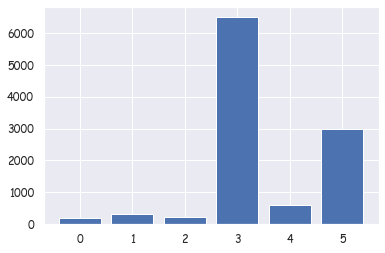

In [43]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [ ]:
df2 = pd.concat([df1,num_df_scaled],axis=1)

In [ ]:
df2.head()

<br>

# MODEL

In [ ]:
x = df[['year','volume(cm3)']]
y = Y

In [ ]:
def find_best_model(X,y):
    algos={
#         'linear_regression':{
#             'model':LinearRegression(),
#             'params':{'normalize':[False,True]}
#                             },
        
        'decision_tree':{
            'model':DecisionTreeRegressor(),
            'params':{'criterion':['mse','friedman_mse'],'splitter':['best','random']}
                },
        
        'RandomForest':{
            'model':RandomForestRegressor(),
            'params':{'criterion':['mse'],'n_estimators':[10,50,100,200,500]}
              }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5,test_size=0.2)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model':algo_name,
            'best_score': gs.best_score_,
            'best_param':gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','best_score','best_param'])

In [ ]:
find_best_model(x,y)   #num features - year and volume

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)
model = RandomForestRegressor()
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [ ]:
r2_score(pred,y_test)

In [ ]:
model.score(X_test,y_test)

In [ ]:
from sklearn.model_selection import cross_val_score
mod = RandomForestRegressor()
scores = cross_val_score(mod, x, y, cv=5)
scores